# RNN

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
except Exception:
    pass

# 이 노트북은 텐서플로 ≥2.4이 필요합니다
# 2.x 버전은 대부분 동일한 결과를 만들지만 몇 가지 버그가 있습니다.
import tensorflow as tf
from tensorflow import keras

# 공통 모듈 임포트
import numpy as np
import pandas as pd

import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "RNN"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action='ignore')

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## 시계열 예측

### 시계열 데이터를 생성해주는 함수

In [2]:
def generate_time_series(batch_size, n_steps):
    #4개의 10000, 1짜리 배열을 생성
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)

    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise

    return series[..., np.newaxis].astype(np.float32)

### 훈련 세트, 검증 세트, 테스트 세트 데이터 생성

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

### 데이터 확인

그림 저장: time_series_plot


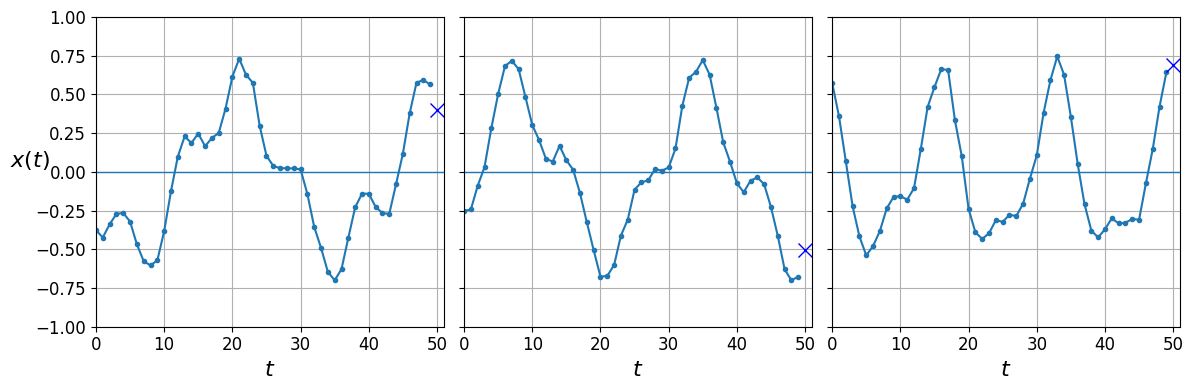

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### 순진한 예측

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

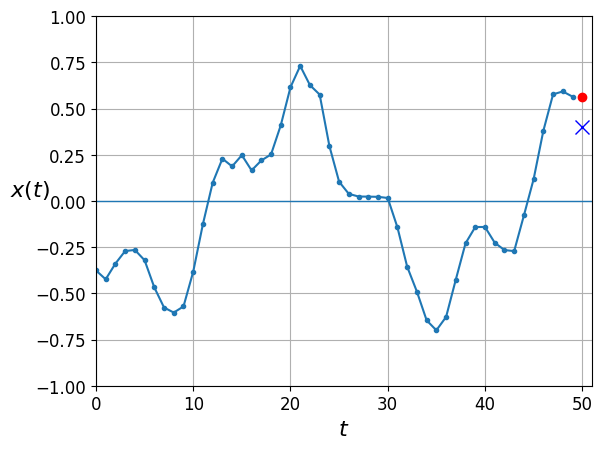

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 완전 연결 네트워크 사용

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

# 순차적으로 층을 쌓는 모델
# 입력은 다음 층이 Dense라면 1차원의 형태로 만들어져야 한다.
# 1차원 만드는 방법은 reshape과 flatten을 사용하는 방법
# 시계열에서는 timestep이 열 개수가 됨.
# 회귀의 출력은 한 개의 뉴런
# 회귀를 구현할 때 중간 Hidden layer를 추가하지 않으면 선형 모델이 된다.
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

# compile
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 4ms/step - loss: 0.0905 - val_loss: 0.0485
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0330 - val_loss: 0.0242
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0192 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0137 - val_loss: 0.0123
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0110 - val_loss: 0.0104
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0059 - val_loss: 0.0058

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0039


0.003934900742024183

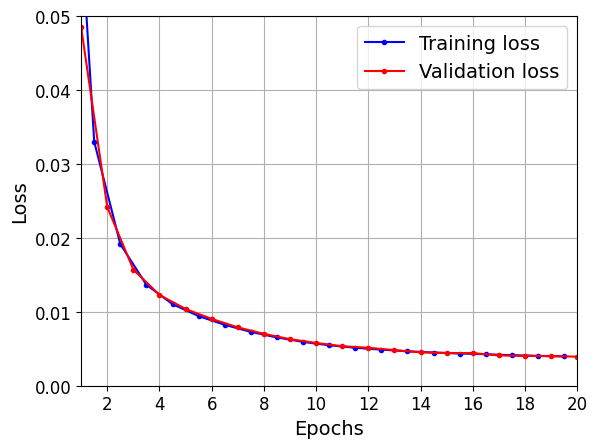

In [14]:
# training loss와 validation loss를 시각화
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 1ms/step


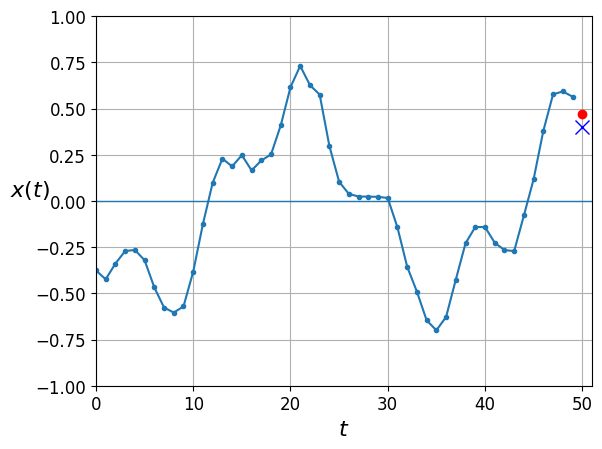

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Simple RNN

In [16]:
# RNN은 어떤 길이의 데이터도 입력으로 받을 수 있어서 입력 차원의 첫번째르 None으로 설정
# 활성화 함수로 tanh 함수를 사용함
# 50개의 데이터를 순서대로 입력받아서 하나의 결과를 예측
# 첫 번재 데이터를 뉴러 과 결합해서 상태를 마들고 이 상태를 다음 뉴런에 입력 값과 합쳐서 전달
# 이전의 상태를 다음 뉴런에게 같이 전달을 해서 이전 상태를 기억

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 10s 40ms/step - loss: 0.3872 - val_loss: 0.3770
Epoch 2/20
219/219 [==============================] - 6s 30ms/step - loss: 0.3400 - val_loss: 0.3311
Epoch 3/20
219/219 [==============================] - 7s 34ms/step - loss: 0.2964 - val_loss: 0.2876
Epoch 4/20
219/219 [==============================] - 13s 57ms/step - loss: 0.2554 - val_loss: 0.2466
Epoch 5/20
219/219 [==============================] - 11s 48ms/step - loss: 0.2176 - val_loss: 0.2094
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.1846 - val_loss: 0.1776
Epoch 7/20
219/219 [==============================] - 7s 34ms/step - loss: 0.1577 - val_loss: 0.1524
Epoch 8/20
219/219 [==============================] - 6s 29ms/step - loss: 0.1366 - val_loss: 0.1330
Epoch 9/20
219/219 [==============================] - 8s 35ms/step - loss: 0.1188 - val_loss: 0.1143
Epoch 10/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0991 - val

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0121


0.012066946364939213

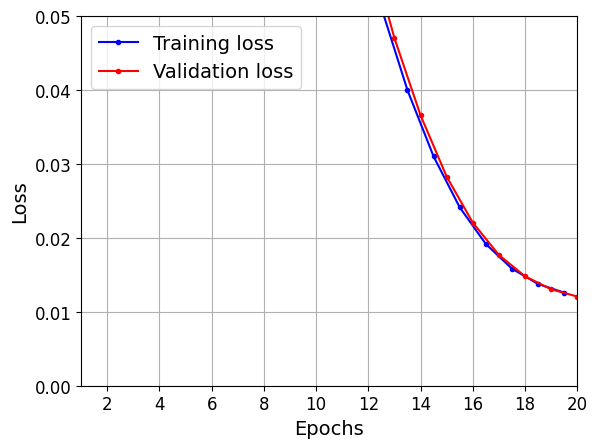

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

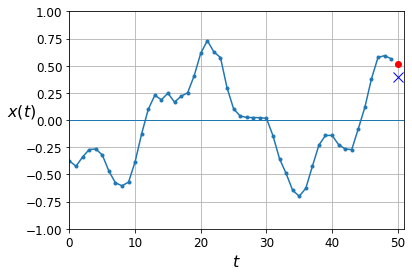

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 심층 RNN

In [19]:
np.random.seed(42)
tf.random.set_seed(42)

# 이전에 비해서 RNN 층을 2개 더 쌓음
# 출력층은 이전 상태를 기억할 필요가 없음
# 마지막 출력 층을 Dense로 변경
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 34s 132ms/step - loss: 0.0379 - val_loss: 0.0096
Epoch 2/20
219/219 [==============================] - 30s 136ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 3/20
219/219 [==============================] - 28s 130ms/step - loss: 0.0051 - val_loss: 0.0043
Epoch 4/20
219/219 [==============================] - 28s 128ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 5/20
219/219 [==============================] - 30s 136ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 6/20
219/219 [==============================] - 39s 179ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 7/20
219/219 [==============================] - 28s 129ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 8/20
219/219 [==============================] - 29s 131ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 29s 132ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 10/20
219/219 [==============================] - 29s 131ms/step - l

#### 출력층 변경

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 21s 86ms/step - loss: 0.0236 - val_loss: 0.0056
Epoch 2/20
219/219 [==============================] - 19s 86ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 3/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 20s 89ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 5/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 6/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 7/20
219/219 [==============================] - 19s 86ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 8/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 9/20
219/219 [==============================] - 18s 84ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/20
219/219 [==============================] - 17s 80ms/step - loss: 0.002

In [23]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0025


0.002528594806790352

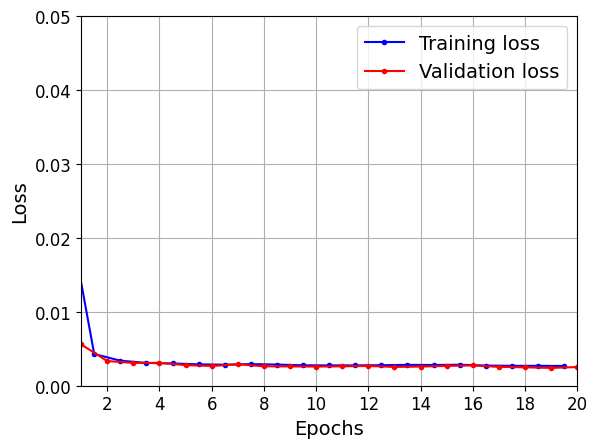

In [24]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 9ms/step


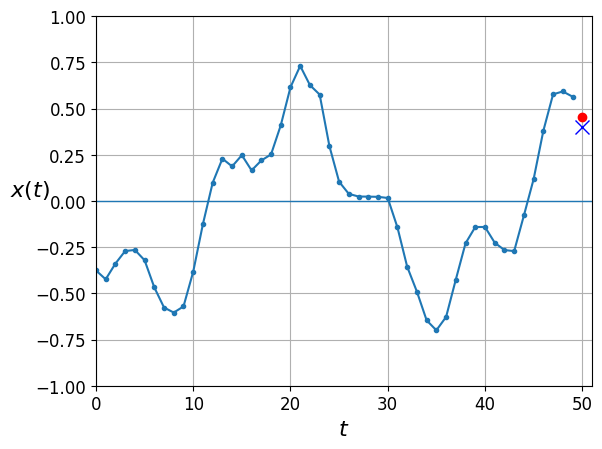

In [25]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 다음 10개의 값 예측하기

#### 이미 훈련된 모델을 이용해서 다음 값을 예측한 다음 이 값을 입력으로 사용

In [26]:
np.random.seed(43)

#60개의 타임 생성
# 60개의 길이를 갖는 시계열 데이터를 ㅐ생성
series = generate_time_series(1, n_steps + 10)
#50개와 10개로 분할
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new


for step_ahead in range(10):
    # 출력되는 값을 새로운 입력으로 사용 - 차원을 늘려줌
    # 처음에는 0번부터 50번까지를 가지고 예측하고 다음에는 1번 부터 51번까지
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]

    # 기존 값에 예측한 값을 추가
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 28ms/step


In [27]:
Y_pred.shape

(1, 10, 1)

그림 저장: forecast_ahead_plot


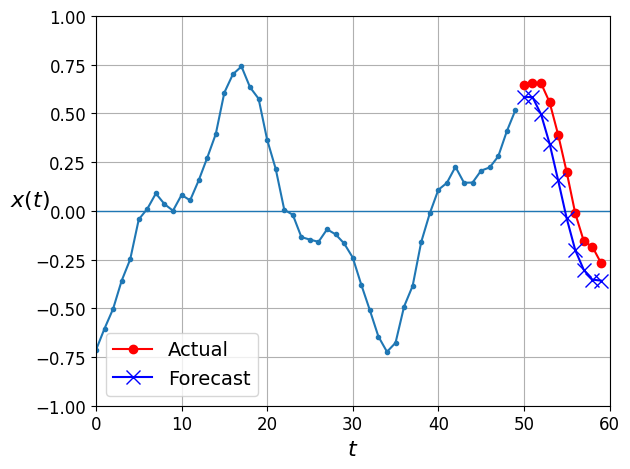

In [28]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

#### 다음 값 10개를 한번에 예측

In [30]:
#타깃을 10개의 값이 담긴 벡터로 변환
n_steps = 50
series = generate_time_series(10000, n_steps + 10)

X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test =series[9000:, :n_steps], series[9000:, -10:, 0]

In [31]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 10))

In [32]:
#출력 층을 10개로 변환
np.random.seed(42)
tf.random.set_seed(42)

# 이전 모델은 하나씩 순서대로 10개를 예측하므로 출력층의 뉴런이 1
# 이번에는 한ㅂ꺼번에 10개를 예측하므로 출력 층의 뉴런이 10
# 입력되는 데이터가 50개의 형태를 가지고 출력하는 데이터가 10개의 형태
# 이런 모델을 sequence to sequence
# 각 RNN 층에 return_sequences를 TRUE로 설정
# 마지막 출력 층의 이전 출력 데이터 전체를 모두 사용해야 하는데 이런 경우 Dense 층을
# TimeDistributed 층으로 감싸야 한다.
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 24s 99ms/step - loss: 0.0749 - val_loss: 0.0469
Epoch 2/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0434 - val_loss: 0.0376
Epoch 3/20
219/219 [==============================] - 20s 90ms/step - loss: 0.0372 - val_loss: 0.0331
Epoch 4/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0322 - val_loss: 0.0269
Epoch 5/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0289 - val_loss: 0.0243
Epoch 6/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0257 - val_loss: 0.0280
Epoch 7/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0242 - val_loss: 0.0226
Epoch 8/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0238 - val_loss: 0.0229
Epoch 9/20
219/219 [==============================] - 19s 85ms/step - loss: 0.0216 - val_loss: 0.0218
Epoch 10/20
219/219 [==============================] - 18s 84ms/step - loss: 0.021

In [33]:
Y_pred = model.predict(X_new)

1/1 [==============================] - 0s 200ms/step


In [34]:
print(Y_pred)

[[-0.33146656 -0.34335348 -0.3307002  -0.27133027 -0.30206528 -0.3182845
  -0.29284057 -0.31153807 -0.2918469  -0.3215884 ]]


#### 개선 - 시퀀스 투 시퀀스 RNN 모델

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)

X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
#각 타겟은 10D 벡터의 시퀀스
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


#모든 출력에서 MSE를 검사하기 위한 함수
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 25ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0366 - val_last_time_step_mse: 0.0265
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0322 - last_time_step_mse: 0.0211 - val_loss: 0.0319 - val_last_time_step_mse: 0.0208
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0297 - last_time_step_mse: 0.0184 - val_loss: 0.0277 - val_last_time_step_mse: 0.0155
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0273 - last_time_step_mse: 0.0153 - val_loss: 0.0269 - val_last_time_step_mse: 0.0171
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0251 - last_time_step_mse: 0.0124 - val_loss: 0.0232 - val_last_time_step_mse: 0.0097
Epoch 7/20
219/219 [==

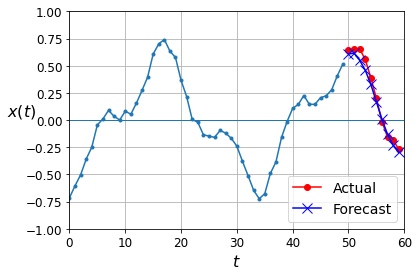

In [ ]:
#예측과 시각화
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## 긴 시퀀스 다루기 - Deep RNNs with Layer Norm

### 배치 정규화 적용

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 9s 27ms/step - loss: 0.1929 - last_time_step_mse: 0.1902 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0537 - last_time_step_mse: 0.0449 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0471 - last_time_step_mse: 0.0375 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0409 - last_time_step_mse: 0.0306 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0385 - last_time_step_mse: 0.0275 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/219 [==

### 층 정규화

In [ ]:
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 15s 47ms/step - loss: 0.1603 - last_time_step_mse: 0.1563 - val_loss: 0.0765 - val_last_time_step_mse: 0.0722
Epoch 2/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0667 - last_time_step_mse: 0.0586 - val_loss: 0.0594 - val_last_time_step_mse: 0.0480
Epoch 3/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0554 - last_time_step_mse: 0.0438 - val_loss: 0.0515 - val_last_time_step_mse: 0.0388
Epoch 4/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0488 - last_time_step_mse: 0.0357 - val_loss: 0.0455 - val_last_time_step_mse: 0.0313
Epoch 5/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0439 - last_time_step_mse: 0.0298 - val_loss: 0.0424 - val_last_time_step_mse: 0.0281
Epoch 6/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0401 - last_time_step_mse: 0.0253 - val_loss: 0.0377 - val_last_time_step_mse: 0.0221
Epoch 7/20
219/2

## 임베딩 레이어를 활용한 Simple RNN

### 임베딩 레이어 생성

In [ ]:
# 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

# 임베딩 레이어
embedding_layer = Embedding(100, 3)
result = embedding_layer(tf.constant([12, 8, 15, 20])) #더미 데이터 입력
print(result)

tf.Tensor(
[[ 0.04166089 -0.01959355 -0.01119081]
 [ 0.04439995 -0.00468044  0.02687681]
 [ 0.02107911 -0.0075531   0.00174569]
 [ 0.04589696  0.03758806  0.02840484]], shape=(4, 3), dtype=float32)


In [ ]:
# 임베딩 레이어 활용
model = Sequential()
model.add(tf.keras.layers.Embedding(100, 3, input_length=32))
model.add(tf.keras.layers.LSTM(units=32))
model.add(tf.keras.layers.Dense(units=1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 3)             300       
                                                                 
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,941
Trainable params: 4,941
Non-trainable params: 0
_________________________________________________________________


## 양방향 RNN

In [ ]:
# Bidirectional LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(Embedding(100,3))
model.add(Bidirectional(LSTM(32))) # 양방향 RNN
model.add(Dense(1))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 3)           300       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9216      
 l)                                                              
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,581
Trainable params: 9,581
Non-trainable params: 0
_________________________________________________________________


## 스태킹 RNN

In [ ]:
# 스태킹RNN 예제
model = Sequential()
model.add(Embedding(100,32))
model.add(LSTM(32, return_sequences=True))  # 전체 시퀀스 출력 (batch_size, timesteps, units)
model.add(LSTM(32))
model.add(Dense(1))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          3200      
                                                                 
 lstm_2 (LSTM)               (None, None, 32)          8320      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,873
Trainable params: 19,873
Non-trainable params: 0
_________________________________________________________________


## 순환 드롭아웃

In [ ]:
# 순환 드룹아웃
model = Sequential()
model.add(Embedding(100, 32))
model.add(LSTM(32, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          3200      
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________


## 자연어 처리

### 토큰화

In [ ]:
# 텐서플로 토크나이저
from tensorflow.keras.preprocessing.text import Tokenizer
sentences = [
             '영실이는 나를 정말 정말 좋아해',
             '영실이는 영화를 좋아해'
]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
print("단어 인덱스:",tokenizer.word_index)

단어 인덱스: {'영실이는': 1, '정말': 2, '좋아해': 3, '나를': 4, '영화를': 5}


### 인코딩 결과

In [ ]:
# 인코딩된 결과
word_encoding = tokenizer.texts_to_sequences(sentences)
word_encoding

[[1, 4, 2, 2, 3], [1, 5, 3]]

### 사전에 없는 단어

In [ ]:
# 사전에 없는 단어가 있을 때 인코딩 결과
new_sentences = ['영실이는 경록이와 나를 좋아해']
new_word_encoding = tokenizer.texts_to_sequences(new_sentences)
new_word_encoding

[[1, 4, 3]]

### 사전에 없는(Out Of Vocabulary) 단어 처리

In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

new_word_encoding = tokenizer.texts_to_sequences(new_sentences)

print(word_index)
print(new_word_encoding)

{'<OOV>': 1, '영실이는': 2, '정말': 3, '좋아해': 4, '나를': 5, '영화를': 6}
[[2, 1, 5, 4]]


### 단어사전 개수 설정

In [ ]:
#앞의 2개 단어만 이용해서 단어를 찾음
tokenizer = Tokenizer(num_words=3, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
new_word_encoding = tokenizer.texts_to_sequences(new_sentences)
print(word_index)
print(new_word_encoding)

{'<OOV>': 1, '영실이는': 2, '정말': 3, '좋아해': 4, '나를': 5, '영화를': 6}
[[2, 1, 1, 1]]


### 문장의 길이 맞추기

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(word_encoding)
print(padded)

[[1 4 2 2 3]
 [0 0 1 5 3]]


In [ ]:
# 패딩(뒤에 0 붙이기)
padded = pad_sequences(word_encoding, padding='post')
print(padded)

[[1 4 2 2 3]
 [1 5 3 0 0]]


In [ ]:
# 문장의 최대 길이 고정
padded = pad_sequences(word_encoding, padding='post',maxlen=4)
print(padded)

[[4 2 2 3]
 [1 5 3 0]]


In [ ]:
# 최대 길이보다 문장이 길 때 뒷부분 자르기
padded = pad_sequences(word_encoding, padding='post', truncating='post', maxlen=4)
print(padded)

[[1 4 2 2]
 [1 5 3 0]]


## Simple RNN 을 이용한 스팸 메일 분류

### import

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 데이터 가져오기

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv',encoding='latin1')

### 데이터 확인

In [ ]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [ ]:
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### 불필요한 열 제거

In [ ]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 데이터 정보 확인

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [ ]:
#null 존재 여부 확인
data.isnull().values.any()

False

In [ ]:
#데이터의 중복 확인
data['v2'].nunique(), data['v1'].nunique()

(5169, 2)

### 중복 제거

In [ ]:
data.drop_duplicates(subset=['v2'], inplace=True) # v2 열에서 중복인 내용이 있다면 중복 제거

In [ ]:
print('총 샘플의 수 :',len(data))
data['v2'].nunique(), data['v1'].nunique()

총 샘플의 수 : 5169


(5169, 2)

### 데이터 분포 확인

<AxesSubplot:>

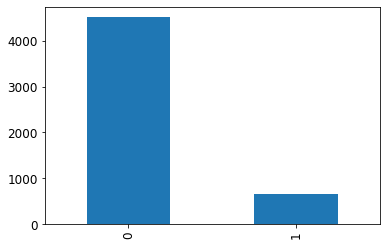

In [ ]:
data['v1'].value_counts().plot(kind='bar')

In [ ]:
print(data.groupby('v1').size().reset_index(name='count'))

   v1  count
0   0   4516
1   1    653


### 피처와 레이블 분리

In [ ]:
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


### 토큰화 숫자화 수행

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(X_data) # 단어를 숫자값, 인덱스로 변환하여 저장

In [ ]:
print(sequences[:5])

[[47, 433, 4013, 780, 705, 662, 64, 8, 1202, 94, 121, 434, 1203, 142, 2712, 1204, 68, 57, 4014, 137], [49, 306, 1364, 435, 6, 1767], [53, 537, 8, 20, 4, 1016, 934, 2, 220, 2713, 1365, 706, 2714, 2715, 267, 2716, 70, 2713, 2, 2717, 2, 359, 537, 604, 1205, 82, 436, 185, 707, 437, 4015], [6, 226, 152, 23, 347, 2718, 6, 138, 145, 56, 152], [935, 1, 97, 96, 69, 453, 2, 877, 69, 1768, 198, 105, 438]]


In [ ]:
#인덱스 확인
word_to_index = tokenizer.word_index
print(word_to_index)

{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'it': 14, 'of': 15, 'have': 16, 'call': 17, 'that': 18, 'on': 19, '2': 20, 'are': 21, 'now': 22, 'so': 23, 'but': 24, 'not': 25, 'can': 26, 'at': 27, 'or': 28, "i'm": 29, 'do': 30, 'be': 31, 'get': 32, 'will': 33, 'just': 34, 'if': 35, 'with': 36, 'we': 37, 'no': 38, 'this': 39, 'ur': 40, 'up': 41, 'gt': 42, 'lt': 43, '4': 44, 'how': 45, 'when': 46, 'go': 47, 'from': 48, 'ok': 49, 'out': 50, 'all': 51, 'what': 52, 'free': 53, 'know': 54, 'like': 55, 'then': 56, 'got': 57, 'good': 58, 'come': 59, 'am': 60, 'was': 61, 'time': 62, 'its': 63, 'only': 64, 'day': 65, 'want': 66, 'love': 67, 'there': 68, 'he': 69, 'text': 70, 'send': 71, 'going': 72, 'one': 73, 'need': 74, 'by': 75, 'lor': 76, 'home': 77, 'as': 78, 'about': 79, 'still': 80, 'see': 81, 'txt': 82, 'back': 83, 'r': 84, 'stop': 85, 'da': 86, 'k': 87, 'today': 88, 'our': 89, "i'll": 90, 'dont': 91, 'reply': 

### 단어의 빈도수 확인

In [ ]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4908
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.02242152466368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.082538108811501


### 단어 집합의 크기 설정

In [ ]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 8921


### 메일의 길이 확인

메일의 최대 길이 : 189
메일의 평균 길이 : 15.610370


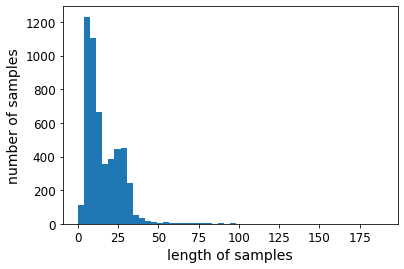

In [ ]:
X_data = sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 문장에 패딩 적용

In [ ]:
max_len = 189
# 전체 데이터셋의 길이는 max_len으로 맞춥니다.
data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", data.shape)

훈련 데이터의 크기(shape):  (5169, 189)


### 훈련 데이터 와 테스트 데이터 분리

In [ ]:
n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 :',n_of_train)
print('테스트 데이터의 개수:',n_of_test)

X_test = data[n_of_train:] #X_data 데이터 중에서 뒤의 1034개의 데이터만 저장
y_test = np.array(y_data[n_of_train:]) #y_data 데이터 중에서 뒤의 1034개의 데이터만 저장
X_train = data[:n_of_train] #X_data 데이터 중에서 앞의 4135개의 데이터만 저장
y_train = np.array(y_data[:n_of_train]) #y_data 데이터 중에서 앞의 4135개의 데이터만 저장

훈련 데이터의 개수 : 4135
테스트 데이터의 개수: 1034


### 모델 생성 및 훈련

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
52/52 [==============================] - 5s 53ms/step - loss: 0.5109 - acc: 0.7579 - val_loss: 0.3531 - val_acc: 0.9274
Epoch 2/10
52/52 [==============================] - 3s 50ms/step - loss: 0.2345 - acc: 0.9338 - val_loss: 0.1175 - val_acc: 0.9710
Epoch 3/10
52/52 [==============================] - 3s 49ms/step - loss: 0.0798 - acc: 0.9791 - val_loss: 0.0801 - val_acc: 0.9782
Epoch 4/10
52/52 [==============================] - 3s 49ms/step - loss: 0.1019 - acc: 0.9622 - val_loss: 0.1622 - val_acc: 0.9407
Epoch 5/10
52/52 [==============================] - 2s 48ms/step - loss: 0.0911 - acc: 0.9698 - val_loss: 0.0902 - val_acc: 0.9758
Epoch 6/10
52/52 [==============================] - 3s 49ms/step - loss: 0.0289 - acc: 0.9933 - val_loss: 0.1041 - val_acc: 0.9577
Epoch 7/10
52/52 [==============================] - 2s 48ms/step - loss: 0.0186 - acc: 0.9949 - val_loss: 0.0593 - val_acc: 0.9819
Epoch 8/10
52/52 [==============================] - 3s 51ms/step - loss: 0.0128 - a

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 0s 12ms/step - loss: 0.0852 - acc: 0.9816

 테스트 정확도: 0.9816


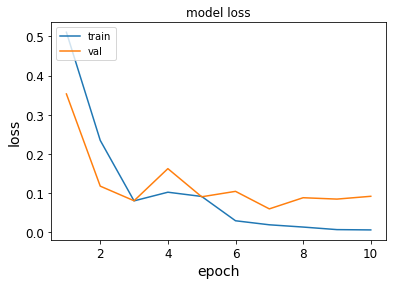

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 순환 신경망으로 IMDB 리뷰 분류

### 자주 사용하는 단어 500개 가져오기

In [ ]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

17473536/17464789 [==============================] - 3s 0us/step


### 데이터 확인

In [ ]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [ ]:
print(len(train_input[0]))

218


In [ ]:
print(len(train_input[1]))

189


In [ ]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [ ]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


### 검증 데이터 분리

In [ ]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

### 리뷰의 길이 확인

In [ ]:
import numpy as np

lengths = np.array([len(x) for x in train_input])

print(np.mean(lengths), np.median(lengths))

239.00925 178.0


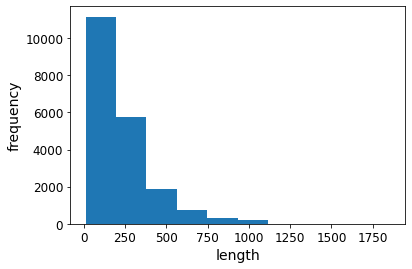

In [ ]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

### 리뷰의 길이 맞추기

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
print(train_seq.shape)

(20000, 100)


In [ ]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [ ]:
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


In [ ]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [ ]:
val_seq = pad_sequences(val_input, maxlen=100)

### 신경망 만들기

In [ ]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
#원핫인코딩
train_oh = keras.utils.to_categorical(train_seq)
print(train_oh.shape)

(20000, 100, 500)


In [ ]:
#처음 12개의 원소만 출력
print(train_oh[0][0][:12])
#원소의 합을 구해서 나머지가 0인지 확인
print(np.sum(train_oh[0][0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
1.0


In [ ]:
#검증 데이터도 원핫 인코딩
val_oh = keras.utils.to_categorical(val_seq)

In [ ]:
#모델 구조 확인
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_13 (SimpleRNN)   (None, 8)                 4072      
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


### 신경망 훈련

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 19s 55ms/step - loss: 0.6964 - accuracy: 0.4972 - val_loss: 0.6946 - val_accuracy: 0.4960
Epoch 2/100
313/313 [==============================] - 17s 53ms/step - loss: 0.6937 - accuracy: 0.5003 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 3/100
313/313 [==============================] - 15s 48ms/step - loss: 0.6924 - accuracy: 0.5102 - val_loss: 0.6927 - val_accuracy: 0.5106
Epoch 4/100
313/313 [==============================] - 16s 51ms/step - loss: 0.6913 - accuracy: 0.5206 - val_loss: 0.6918 - val_accuracy: 0.5178
Epoch 5/100
313/313 [==============================] - 16s 50ms/step - loss: 0.6901 - accuracy: 0.5304 - val_loss: 0.6911 - val_accuracy: 0.5218
Epoch 6/100
313/313 [==============================] - 16s 51ms/step - loss: 0.6889 - accuracy: 0.5384 - val_loss: 0.6905 - val_accuracy: 0.5252
Epoch 7/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6877 - accuracy: 0.5436 - val_loss: 0.6898 - val_ac

### 손실 그래프

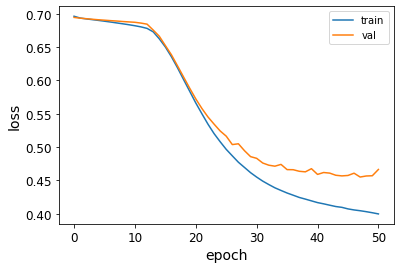

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 단어 임베딩 사용하기

In [ ]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 16)           8000      
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 8)                 200       
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 10s 25ms/step - loss: 0.6848 - accuracy: 0.5567 - val_loss: 0.6747 - val_accuracy: 0.5970
Epoch 2/100
313/313 [==============================] - 8s 24ms/step - loss: 0.6591 - accuracy: 0.6462 - val_loss: 0.6564 - val_accuracy: 0.6534
Epoch 3/100
313/313 [==============================] - 7s 24ms/step - loss: 0.6372 - accuracy: 0.6952 - val_loss: 0.6313 - val_accuracy: 0.7176
Epoch 4/100
313/313 [==============================] - 8s 24ms/step - loss: 0.6167 - accuracy: 0.7258 - val_loss: 0.6139 - val_accuracy: 0.7224
Epoch 5/100
313/313 [==============================] - 7s 23ms/step - loss: 0.5964 - accuracy: 0.7394 - val_loss: 0.5918 - val_accuracy: 0.7464
Epoch 6/100
313/313 [==============================] - 8s 24ms/step - loss: 0.5754 - accuracy: 0.7548 - val_loss: 0.5716 - val_accuracy: 0.7536
Epoch 7/100
313/313 [==============================] - 8s 25ms/step - loss: 0.5538 - accuracy: 0.7645 - val_loss: 0.5519 - val_accuracy

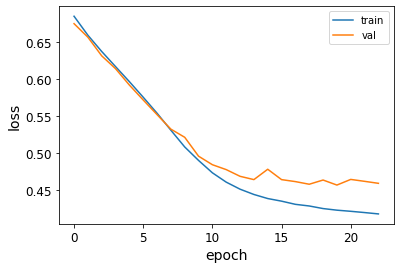

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##  LSTM 이용한 IMDB 감성 분석

### 데이터 가져오기

In [ ]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

### 데이터 길이 맞추기

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

### 모델 만들기

In [ ]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_5 (LSTM)               (None, 8)                 800       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 20s 48ms/step - loss: 0.6920 - accuracy: 0.5575 - val_loss: 0.6911 - val_accuracy: 0.5974
Epoch 2/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6889 - accuracy: 0.6324 - val_loss: 0.6868 - val_accuracy: 0.6512
Epoch 3/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6805 - accuracy: 0.6733 - val_loss: 0.6727 - val_accuracy: 0.6804
Epoch 4/100
313/313 [==============================] - 14s 43ms/step - loss: 0.6397 - accuracy: 0.7121 - val_loss: 0.6087 - val_accuracy: 0.7190
Epoch 5/100
313/313 [==============================] - 14s 43ms/step - loss: 0.5891 - accuracy: 0.7354 - val_loss: 0.5803 - val_accuracy: 0.7400
Epoch 6/100
313/313 [==============================] - 14s 45ms/step - loss: 0.5665 - accuracy: 0.7489 - val_loss: 0.5607 - val_accuracy: 0.7448
Epoch 7/100
313/313 [==============================] - 14s 44ms/step - loss: 0.5464 - accuracy: 0.7613 - val_loss: 0.5423 - val_ac

### 손실 시각화

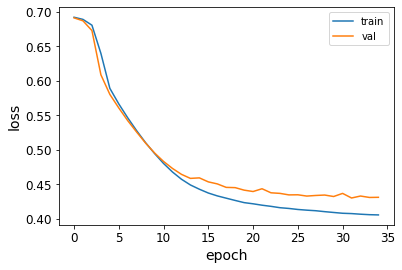

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 드롭 아웃 적용

In [ ]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 21s 49ms/step - loss: 0.6925 - accuracy: 0.5351 - val_loss: 0.6919 - val_accuracy: 0.5548
Epoch 2/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6908 - accuracy: 0.5869 - val_loss: 0.6897 - val_accuracy: 0.5956
Epoch 3/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6873 - accuracy: 0.6240 - val_loss: 0.6846 - val_accuracy: 0.6484
Epoch 4/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6729 - accuracy: 0.6863 - val_loss: 0.6496 - val_accuracy: 0.7158
Epoch 5/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6238 - accuracy: 0.7038 - val_loss: 0.6116 - val_accuracy: 0.7062
Epoch 6/100
313/313 [==============================] - 13s 43ms/step - loss: 0.6021 - accuracy: 0.7128 - val_loss: 0.5936 - val_accuracy: 0.7140
Epoch 7/100
313/313 [==============================] - 14s 45ms/step - loss: 0.5825 - accuracy: 0.7269 - val_loss: 0.5741 - val_ac

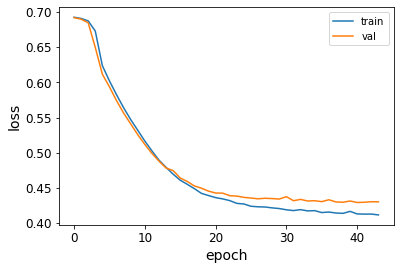

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 2개의 층 연결하기

In [ ]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_7 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_8 (LSTM)               (None, 8)                 544       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 33s 86ms/step - loss: 0.6924 - accuracy: 0.5428 - val_loss: 0.6915 - val_accuracy: 0.6158
Epoch 2/100
313/313 [==============================] - 26s 83ms/step - loss: 0.6885 - accuracy: 0.6323 - val_loss: 0.6833 - val_accuracy: 0.6794
Epoch 3/100
313/313 [==============================] - 26s 82ms/step - loss: 0.6597 - accuracy: 0.6921 - val_loss: 0.6214 - val_accuracy: 0.7146
Epoch 4/100
313/313 [==============================] - 25s 80ms/step - loss: 0.5816 - accuracy: 0.7221 - val_loss: 0.5596 - val_accuracy: 0.7248
Epoch 5/100
313/313 [==============================] - 25s 81ms/step - loss: 0.5472 - accuracy: 0.7356 - val_loss: 0.5357 - val_accuracy: 0.7426
Epoch 6/100
313/313 [==============================] - 26s 82ms/step - loss: 0.5284 - accuracy: 0.7488 - val_loss: 0.5162 - val_accuracy: 0.7536
Epoch 7/100
313/313 [==============================] - 27s 88ms/step - loss: 0.5149 - accuracy: 0.7567 - val_loss: 0.5030 - val_ac

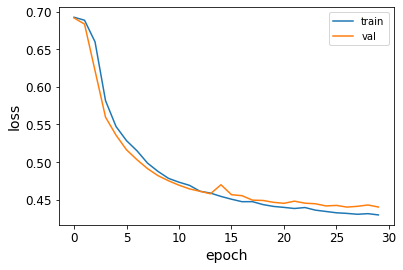

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 로이터 뉴스 기사 분류

### import

In [ ]:
from tensorflow.keras.datasets import reuters
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### 데이터 가져오기

In [ ]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

print('훈련용 뉴스 기사 : {}'.format(len(X_train)))
print('테스트용 뉴스 기사 : {}'.format(len(X_test)))
num_classes = max(y_train) + 1
print('카테고리 : {}'.format(num_classes))

2121728/2110848 [==============================] - 0s 0us/step
훈련용 뉴스 기사 : 8982
테스트용 뉴스 기사 : 2246
카테고리 : 46


In [ ]:
print(X_train[0]) # 첫번째 훈련용 뉴스 기사
print(y_train[0]) # 첫번째 훈련용 뉴스 기사의 레이블

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


### 각 기사의 길이 확인

뉴스 기사의 최대 길이 :2376
뉴스 기사의 평균 길이 :145.5398574927633


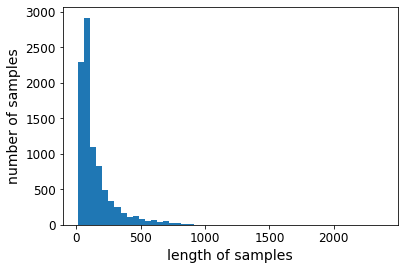

In [ ]:
print('뉴스 기사의 최대 길이 :{}'.format(max(len(l) for l in X_train)))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 레이블의 분포 확인

<AxesSubplot:ylabel='count'>

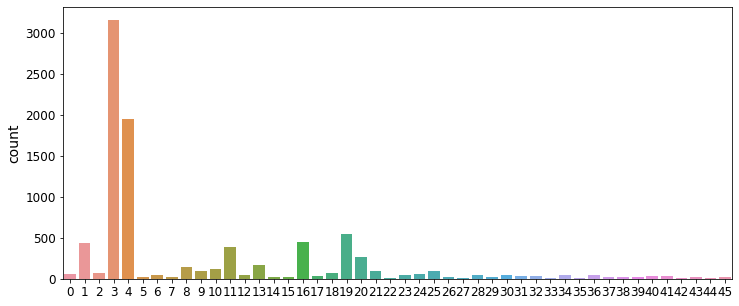

In [ ]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))
# label_cnt=dict(zip(unique_elements, counts_elements))
# 아래의 출력 결과가 보기 불편하여 병렬로 보고싶다면 위의 label_cnt를 출력

각 레이블에 대한 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 단어 확인

In [ ]:
word_to_index = reuters.get_word_index()
print(word_to_index)

565248/550378 [==============================] - 0s 0us/step
{'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, 'woods': 8803, 'hanging': 13796, 'localized': 20672, 'sation': 20673, 'chanthaburi': 20675, 'refunding': 10997, 'hermann': 8804, 'passsengers': 20676, 'stipulate': 20677, 'heublein': 8352, 'screaming': 20713, 'tcby': 16261, 'four': 185, 'grains': 1642, 'broiler': 20680, 'wooden': 12090, 'wednesday': 1220, 'highveld': 13797, 'duffour': 7593, '0053': 20681, 'elections': 3914, '270': 2563, '271': 3551, '272': 5113, '273': 3552, '274': 3400, 'rudman': 7975, '276': 3401, '277': 3478, '278': 3632, '279': 4309, 'dormancy': 9381, 'errors': 7247, 'deferred': 3086, 'sptnd': 20683, 'cooking': 8805, 'stratabit': 20684, 'designing': 16262, 'metalurgicos': 20685, 'databank': 13798, '300er': 20686, 'shocks': 20687, 'nawg': 7972, 'tnta': 20688, 'perforations': 20689, 'affiliates': 2891, '27p': 20690, 'ching': 16263, 'china': 595, 'wagyu': 16264, 'affiliated': 3189, 'chino': 16265, 'chinh': 162

In [ ]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

print('빈도수 상위 28842번 단어 : {}'.format(index_to_word[28842]))
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))

빈도수 상위 28842번 단어 : nondiscriminatory
빈도수 상위 1번 단어 : the


In [ ]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

print(' '.join([index_to_word[index] for index in X_train[0]]))

<sos> wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs


### 모델 생성 및 훈련을 위한 import

In [ ]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

### 데이터 전처리

In [ ]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len) # 훈련용 뉴스 기사 패딩
X_test = pad_sequences(X_test, maxlen=max_len) # 테스트용 뉴스 기사 패딩

y_train = to_categorical(y_train) # 훈련용 뉴스 기사 레이블의 원-핫 인코딩
y_test = to_categorical(y_test) # 테스트용 뉴스 기사 레이블의 원-핫 인코딩

### 모델 생성 및 훈련

In [ ]:
model = Sequential()
model.add(Embedding(1000, 120))
model.add(LSTM(120))
model.add(Dense(46, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/30
70/71 [============================>.] - ETA: 0s - loss: 2.6136 - acc: 0.3461
Epoch 1: val_acc improved from -inf to 0.36198, saving model to best_model.h5
71/71 [==============================] - 13s 162ms/step - loss: 2.6137 - acc: 0.3462 - val_loss: 2.4169 - val_acc: 0.3620
Epoch 2/30
71/71 [==============================] - ETA: 0s - loss: 2.3275 - acc: 0.3899
Epoch 2: val_acc improved from 0.36198 to 0.49510, saving model to best_model.h5
71/71 [==============================] - 12s 162ms/step - loss: 2.3275 - acc: 0.3899 - val_loss: 2.1030 - val_acc: 0.4951
Epoch 3/30
70/71 [============================>.] - ETA: 0s - loss: 2.0728 - acc: 0.4933
Epoch 3: val_acc improved from 0.49510 to 0.50579, saving model to best_model.h5
71/71 [==============================] - 11s 156ms/step - loss: 2.0730 - acc: 0.4935 - val_loss: 2.0263 - val_acc: 0.5058
Epoch 4/30
71/71 [==============================] - ETA: 0s - loss: 2.0056 - acc: 0.5070
Epoch 4: val_acc improved from 0.50579

### 정확도 확인

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

71/71 [==============================] - 3s 24ms/step - loss: 1.2025 - acc: 0.7195

 테스트 정확도: 0.7195


### 손실 확인

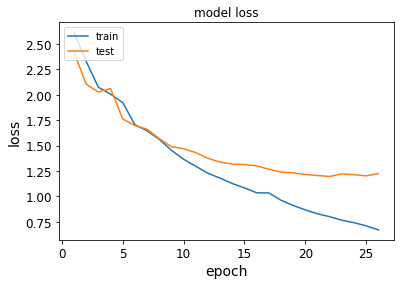

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## LSTM을 이용한 주가 예측

### 라이브러리 import

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from pandas.io.parsers import read_csv

In [ ]:
# colab 사용자는 파일을 파일 업로드 수행
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

### 데이터 읽어오기

In [ ]:
data = pd.read_csv('./data/kakao.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-11,54600.0,54600.0,54600.0,54600.0,51524.144531,276500.0
1,2000-02-14,52800.0,59600.0,48100.0,49400.0,46617.078125,6270500.0
2,2000-02-15,50000.0,51800.0,43500.0,43500.0,41049.457031,3243000.0
3,2000-02-16,42000.0,48700.0,40000.0,48700.0,45956.519531,4357000.0
4,2000-02-17,49200.0,53500.0,47000.0,48700.0,45956.519531,5099000.0


### 전처리

In [ ]:
#결측치 제거
data = data.dropna(axis=0)

In [ ]:
#가장 높은 가격 과 낮은 가격의 중간값을 생성
high_price = data['High'].values
low_price = data['Low'].values
mid_price = (high_price + low_price) / 2

In [ ]:
#데이터들을 첫날부터 50일씩 끊어서 저장
#[ [0~50일], [1~51일], [2~52일], [3~53일]....... ]
# 50일 치 데이터를 가지고 51일째 되는 날의 주가를 예측하기 위해서

day_divided = 50
day_length = day_divided + 1
day_result = []
for i in range(len(mid_price) - day_length):
    day_result.append(mid_price[i: i + day_length])

In [ ]:
#분리된 데이터 확인
print("전체 데이터 Length : ", len(data))
print("나눈 데이터 Length : ", len(day_result))
print("나눈 데이터 0번째 : ")
print(day_result[0])
print(day_result[1])

전체 데이터 Length :  5385
나눈 데이터 Length :  5334
나눈 데이터 0번째 : 
[54600. 53850. 47650. 44350. 50250. 48150. 42950. 41300. 36550. 39150.
 41950. 38850. 37350. 36800. 36800. 32300. 30950. 29400. 31400. 33400.
 36500. 33600. 29600. 28800. 29700. 27450. 23900. 21800. 23600. 22900.
 22100. 22450. 23350. 21600. 20600. 22400. 19920. 17910. 17560. 18380.
 19190. 21750. 21650. 19400. 19400. 17740. 15040. 14910. 14100. 12830.
 13170.]
[53850. 47650. 44350. 50250. 48150. 42950. 41300. 36550. 39150. 41950.
 38850. 37350. 36800. 36800. 32300. 30950. 29400. 31400. 33400. 36500.
 33600. 29600. 28800. 29700. 27450. 23900. 21800. 23600. 22900. 22100.
 22450. 23350. 21600. 20600. 22400. 19920. 17910. 17560. 18380. 19190.
 21750. 21650. 19400. 19400. 17740. 15040. 14910. 14100. 12830. 13170.
 13380.]


In [ ]:
#50일씩 나누었던 데이터들을 첫날 기준으로 정규화 진행
#첫날을 0으로 만들고, 나머지 날들은 그 비율로 나누어 정규화

norm_result = []
for section in day_result:
    norm_section = [((float(p) / float(section[0])) - 1) for p in section]
    norm_result.append(norm_section)
day_result = np.array(norm_result)

print(day_result[0])

[ 0.         -0.01373626 -0.12728938 -0.18772894 -0.07967033 -0.11813187
 -0.21336996 -0.24358974 -0.33058608 -0.28296703 -0.23168498 -0.28846154
 -0.31593407 -0.32600733 -0.32600733 -0.40842491 -0.43315018 -0.46153846
 -0.42490842 -0.38827839 -0.33150183 -0.38461538 -0.45787546 -0.47252747
 -0.45604396 -0.49725275 -0.56227106 -0.6007326  -0.56776557 -0.58058608
 -0.5952381  -0.58882784 -0.57234432 -0.6043956  -0.62271062 -0.58974359
 -0.63516484 -0.67197802 -0.67838828 -0.66336996 -0.6485348  -0.60164835
 -0.60347985 -0.64468864 -0.64468864 -0.67509158 -0.72454212 -0.72692308
 -0.74175824 -0.76501832 -0.75879121]


### 훈련 데이터 와 검증 데이터 만들기

In [ ]:
train_data_rate = 0.9
boundary = round(day_result.shape[0] * train_data_rate)
train_data = day_result[:boundary, :]
test_data = day_result[boundary:, :]

x_train = train_data[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train_data[:, -1]

x_test = test_data[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test_data[:, -1]

x_train.shape, x_test.shape

((4801, 50, 1), (533, 50, 1))

### 모델 생성 및 구조 확인

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer='sgd')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련

In [ ]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=15)

Epoch 1/15
481/481 [==============================] - 13s 22ms/step - loss: 0.0540 - val_loss: 0.0827
Epoch 2/15
481/481 [==============================] - 10s 22ms/step - loss: 0.0540 - val_loss: 0.0827
Epoch 3/15
481/481 [==============================] - 10s 21ms/step - loss: 0.0540 - val_loss: 0.0827
Epoch 4/15
481/481 [==============================] - 10s 21ms/step - loss: 0.0540 - val_loss: 0.0827
Epoch 5/15
481/481 [==============================] - 11s 22ms/step - loss: 0.0540 - val_loss: 0.0827
Epoch 6/15
481/481 [==============================] - 10s 21ms/step - loss: 0.0540 - val_loss: 0.0827
Epoch 7/15
481/481 [==============================] - 10s 22ms/step - loss: 0.0540 - val_loss: 0.0827
Epoch 8/15
481/481 [==============================] - 10s 21ms/step - loss: 0.0540 - val_loss: 0.0827
Epoch 9/15
481/481 [==============================] - 10s 21ms/step - loss: 0.0540 - val_loss: 0.0827
Epoch 10/15
481/481 [==============================] - 10s 21ms/step - loss: 0.054

### 결과 예측 및 시각화

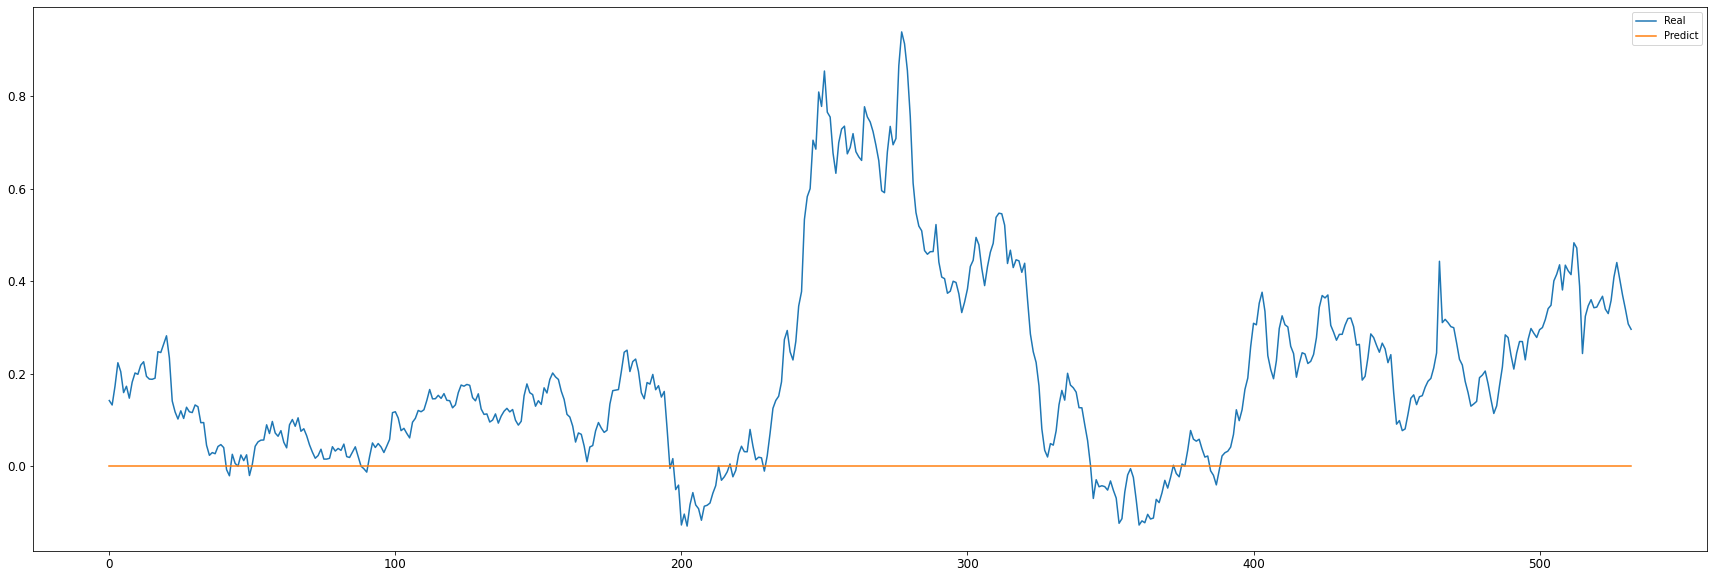

In [ ]:
pred = model.predict(x_test)

import matplotlib.pyplot as plt

plot_figure = plt.figure(figsize=(30, 10))
plot_rst = plot_figure.add_subplot(111)
plot_rst.plot(y_test, label='Real')
plot_rst.plot(pred, label='Predict')
plot_rst.legend()
plt.show()

## GRU

### 데이터 가져오기

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

### 신경망 훈련

In [ ]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 10s 28ms/step - loss: 0.6925 - accuracy: 0.5253 - val_loss: 0.6918 - val_accuracy: 0.5398
Epoch 2/100
313/313 [==============================] - 9s 27ms/step - loss: 0.6901 - accuracy: 0.5810 - val_loss: 0.6891 - val_accuracy: 0.5672
Epoch 3/100
313/313 [==============================] - 9s 28ms/step - loss: 0.6863 - accuracy: 0.5961 - val_loss: 0.6848 - val_accuracy: 0.5826
Epoch 4/100
313/313 [==============================] - 9s 27ms/step - loss: 0.6802 - accuracy: 0.6090 - val_loss: 0.6779 - val_accuracy: 0.6046
Epoch 5/100
313/313 [==============================] - 9s 28ms/step - loss: 0.6706 - accuracy: 0.6237 - val_loss: 0.6674 - val_accuracy: 0.6176
Epoch 6/100
313/313 [==============================] - 9s 28ms/step - loss: 0.6560 - accuracy: 0.6399 - val_loss: 0.6511 - val_accuracy: 0.6336
Epoch 7/100
313/313 [==============================] - 9s 28ms/step - loss: 0.6333 - accuracy: 0.6614 - val_loss: 0.6248 - val_accuracy

### 손실 그래프

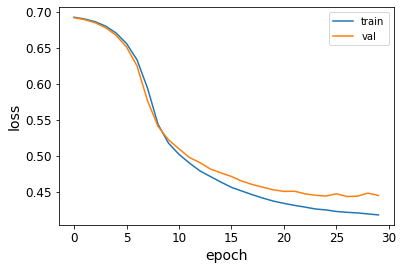

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 이전 모델을 호출해서 평가

In [ ]:
test_seq = pad_sequences(test_input, maxlen=100)

rnn_model = keras.models.load_model('best-gru-model.h5')
# 텐서플로 2.3에서는 버그(https://github.com/tensorflow/tensorflow/issues/42890) 때문에 compile() 메서드를 호출해야 합니다.
# rnn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics='accuracy')

rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 4s 5ms/step - loss: 0.4390 - accuracy: 0.7977


[0.43904706835746765, 0.7977200150489807]